In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
ds = pd.read_csv("sample-data.csv")
ds.head()

,id,description
0,1,Active classic boxers - There's a reason why o...
1,2,Active sport boxer briefs - Skinning up Glory ...
2,3,Active sport briefs - These superbreathable no...
3,4,"Alpine guide pants - Skin in, climb ice, switc..."
4,5,"Alpine wind jkt - On high ridges, steep ice an..."


In [3]:
print('unique words: ', len(ds['description'].str.split(' ', expand=True).stack().unique()))
ds.description.values[0]

unique words:  9844


'Active classic boxers - There\'s a reason why our boxers are a cult favorite - they keep their cool, especially in sticky situations. The quick-drying, lightweight underwear takes up minimal space in a travel pack. An exposed, brushed waistband offers next-to-skin softness, five-panel construction with a traditional boxer back for a classic fit, and a functional fly. Made of 3.7-oz 100% recycled polyester with moisture-wicking performance. Inseam (size M) is 4 1/2". Recyclable through the Common Threads Recycling Program.<br><br><b>Details:</b><ul> <li>"Silky Capilene 1 fabric is ultralight, breathable and quick-to-dry"</li> <li>"Exposed, brushed elastic waistband for comfort"</li> <li>5-panel construction with traditional boxer back</li> <li>"Inseam (size M) is 4 1/2"""</li></ul><br><br><b>Fabric: </b>3.7-oz 100% all-recycled polyester with Gladiodor natural odor control for the garment. Recyclable through the Common Threads Recycling Program<br><br><b>Weight: </b>99 g (3.5 oz)<br><b

In [4]:
ds['title']=ds['description'].apply(lambda x: x.split(' - ',1)[0])
ds['description']=ds['description'].apply(lambda x: x.split(' - ',1)[1])
ds.head()

,id,description,title
0,1,There's a reason why our boxers are a cult fav...,Active classic boxers
1,2,Skinning up Glory requires enough movement wit...,Active sport boxer briefs
2,3,These superbreathable no-fly briefs are the mi...,Active sport briefs
3,4,"Skin in, climb ice, switch to rock, traverse a...",Alpine guide pants
4,5,"On high ridges, steep ice and anything alpine,...",Alpine wind jkt


In [5]:
ds[['description','title']].duplicated().any()

False

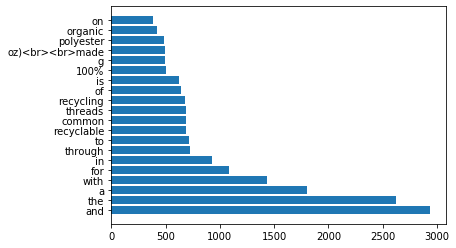

In [6]:
from nltk.probability import FreqDist
fdist=ds.description.values
dist=FreqDist(word.lower() for l in list(fdist) for word in l.split(' '))
plt.barh(*zip(*dist.most_common(n=20)));

In [7]:
from bs4 import BeautifulSoup
ds.description=ds.description.apply(lambda x: 
                BeautifulSoup(x).get_text())
print('unique words: ', len(ds['description'].str.
            split(' ', expand=True).stack().unique()))
fdist[0]

unique words:  9149


'There\'s a reason why our boxers are a cult favorite - they keep their cool, especially in sticky situations. The quick-drying, lightweight underwear takes up minimal space in a travel pack. An exposed, brushed waistband offers next-to-skin softness, five-panel construction with a traditional boxer back for a classic fit, and a functional fly. Made of 3.7-oz 100% recycled polyester with moisture-wicking performance. Inseam (size M) is 4 1/2". Recyclable through the Common Threads Recycling Program.Details: "Silky Capilene 1 fabric is ultralight, breathable and quick-to-dry" "Exposed, brushed elastic waistband for comfort" 5-panel construction with traditional boxer back "Inseam (size M) is 4 1/2"""Fabric: 3.7-oz 100% all-recycled polyester with Gladiodor natural odor control for the garment. Recyclable through the Common Threads Recycling ProgramWeight: 99 g (3.5 oz)Made in Mexico.'

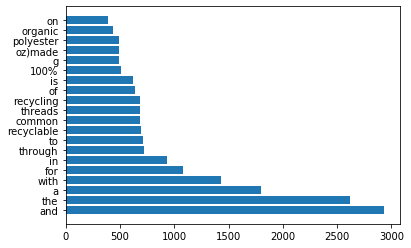

In [8]:
fdist=ds.description.values
dist=FreqDist(word.lower() for l in list(fdist) for word in l.split(' '))
plt.barh(*zip(*dist.most_common(n=20)));

In [9]:
import string
from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer=WordNetLemmatizer()
ds.description=ds.description.apply(lambda x:
        ''.join([c for c in x if c not in string.punctuation]))
print('unique words after removing punctuation: ', 
        len(ds['description'].str.split(' ', expand=True).stack().unique()))
ds.description=ds.description.apply(lambda x:
        ' '.join([lemmatizer.lemmatize(i,pos='v') for i in x.split(' ')]))
print('unique words after lemmatizing: ',
      len(ds['description'].str.split(' ', expand=True).stack().unique()))
ds.head()

unique words after removing punctuation:  6687
unique words after lemmatizing:  5974


,id,description,title
0,1,Theres a reason why our boxers be a cult favor...,Active classic boxers
1,2,Skinning up Glory require enough movement with...,Active sport boxer briefs
2,3,These superbreathable nofly brief be the minim...,Active sport briefs
3,4,Skin in climb ice switch to rock traverse a kn...,Alpine guide pants
4,5,On high ridge steep ice and anything alpine th...,Alpine wind jkt


In [10]:
tf = TfidfVectorizer(analyzer='word', min_df=0, 
                     ngram_range=(1, 1),stop_words='english')
tfidf_matrix = tf.fit_transform(ds['description'])
cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_similarities.shape

(500, 500)

In [11]:
results = {}
for idx in range(ds.shape[0]):
    similar_indices = cosine_similarities[idx].argsort()[:-100:-1]
    similar_items = [(cosine_similarities[idx][i], 
                      ds['id'][i]) for i in similar_indices]

    results[ds.loc[idx,'id']] = similar_items[1:]

In [12]:
def recommend(item_id, num, result):
    print("Recommending " + str(num) + " products similar to " + 
          ds.loc[ds['id'] == item_id]['title'].tolist()[0] + "...")
    print("---------------------------------------------------------------")
    recs = result[item_id][:num]
    for rec in recs:
        print("Recommended: " + ds.loc[ds['id'] == rec[1]]['title'].tolist()[0]
              + " (score:" + str(rec[0]) + ")")

In [13]:
recommend(item_id=20, num=5, result=results)

Recommending 5 products similar to Cap 1 graphic t-shirt...
---------------------------------------------------------------
Recommended: Cap 1 graphic t-shirt (score:0.8004655856820306)
Recommended: Cap 1 graphic crew (score:0.7355441761215598)
Recommended: Cap 1 crew (score:0.7156250259795652)
Recommended: Cap 1 t-shirt (score:0.6958350039009054)
Recommended: Cap 1 t-shirt (score:0.6771587938873325)


unique words:  473


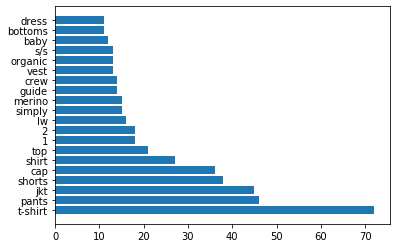

In [14]:
fdist=ds.title.values
dist=FreqDist(word.lower() for l in list(fdist) for word in l.split(' '))
print('unique words: ', len(ds['title'].str.split(' ', expand=True).stack().unique()))
plt.barh(*zip(*dist.most_common(n=20)));

In [15]:
ds.title=ds.title.apply(lambda x:''.join([c for c in x if c not in string.punctuation]))
print('unique words after removing punctuations: ', len(ds['title'].str.split(' ', expand=True).stack().unique()))
ds.title=ds.title.apply(lambda x:' '.join([lemmatizer.lemmatize(i,pos='v') for i in x.split(' ')]))
print('unique words after lemmatizing: ',len(ds['title'].str.split(' ', expand=True).stack().unique()))
ds.head()

unique words after removing punctuations:  471
unique words after lemmatizing:  470


,id,description,title
0,1,Theres a reason why our boxers be a cult favor...,Active classic boxers
1,2,Skinning up Glory require enough movement with...,Active sport boxer brief
2,3,These superbreathable nofly brief be the minim...,Active sport brief
3,4,Skin in climb ice switch to rock traverse a kn...,Alpine guide pant
4,5,On high ridge steep ice and anything alpine th...,Alpine wind jkt


In [16]:
tfidf_matrix2 = tf.fit_transform(ds['title'])
cosine_similarities2 = linear_kernel(tfidf_matrix2, tfidf_matrix2)
cosine_similarities2.shape

(500, 500)

In [17]:
results2 = {}
for idx in range(ds.shape[0]):
    similar_indices2 = cosine_similarities2[idx].argsort()[:-100:-1]
    similar_items2 = [(cosine_similarities2[idx][i], ds['id'][i]) for i in similar_indices2]

    results2[ds.loc[idx, 'id']] = similar_items2[1:]

In [18]:
recommend(item_id=20, num=5, result=results2)

Recommending 5 products similar to Cap 1 graphic tshirt...
---------------------------------------------------------------
Recommended: Cap 1 graphic tshirt (score:1.0)
Recommended: Cap 1 graphic crew (score:0.7509072619887835)
Recommended: Merino 1 graphic tshirt (score:0.6987926419192083)
Recommended: Cap 1 graphic tee (score:0.6922859807917122)
Recommended: Cap 2 tshirt (score:0.6520047984269309)
